# EzaSmart ML Model Notebook
## Hydroponics Software System

**Author:** Afsa Umutoniwase  
**Project:** Bridging Knowledge Gaps with Hydroponics Software System  
**Date:** 2026

This notebook contains:
1. Data Visualization and Data Engineering
2. Model Architecture
3. Initial Performance Metrics
4. Deployment Option (Flask API with Swagger UI)


In [136]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import json
import os
from pathlib import Path

warnings.filterwarnings('ignore')

# Base and results directories
BASE_DIR = Path(r"C:\Users\HP\Desktop\ALU\capstone")
RESULTS_DIR = BASE_DIR / "Results"
RESULTS_DIR.mkdir(exist_ok=True)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Data Loading and Exploration


In [137]:
# Load IoT Sensor Data (Kaggle)
import os

print("IoT DATA (Kaggle - Sensor & Actuator Logs)")
iot_data = pd.read_csv('Kaggle data/IoTData --Raw--.csv')
print(f"IoT Data Shape: {iot_data.shape}")
print(f"Columns: {list(iot_data.columns)}")
print(f"\nFirst few rows:")
display(iot_data.head())


IoT DATA (Kaggle - Sensor & Actuator Logs)
IoT Data Shape: (50570, 13)
Columns: ['id', 'timestamp', 'pH', 'TDS', 'water_level', 'DHT_temp', 'DHT_humidity', 'water_temp', 'pH_reducer', 'add_water', 'nutrients_adder', 'humidifier', 'ex_fan']

First few rows:


,id,timestamp,pH,TDS,water_level,DHT_temp,DHT_humidity,water_temp,pH_reducer,add_water,nutrients_adder,humidifier,ex_fan
0,1,2023-11-26 10:57:52,7.0,500.0,0,25.5,60.0,20.0,ON,NaN,OFF,OFF,ON
1,2,2023-11-26 10:58:37,7.0,500.0,0,25.5,60.0,20.0,ON,NaN,OFF,OFF,OFF
2,3,2023-11-26 11:01:34,7.0,500.0,3,25.5,60.0,20.0,ON,NaN,OFF,OFF,OFF
3,4,2023-12-05 11:30:58,7.0,500.0,3,25.5,60.0,20.0,ON,NaN,OFF,OFF,OFF
4,5,2023-12-05 11:33:50,7.0,500.0,3,25.5,60.0,20.0,ON,ON,OFF,OFF,OFF


In [138]:
# Data Overview
print("DATASET OVERVIEW")
print(f"\n1. IoT Data (Kaggle Repository):")
print(f"   - Source: Hydroponics IoT Sensor & Actuator Logs")
print(f"   - Records: {len(iot_data):,}")
print(f"   - Columns: {iot_data.shape[1]}")
print(f"   - Key Features: pH, TDS (to EC), Temperature, Actuator States")
print(f"   - Missing Values: {iot_data.isnull().sum().sum()}")

print(f"\n2. Synthetic Data (Rwanda Context):")
print(f"   - Records: 5,000 (to be generated)")
print(f"   - Based on: Oklahoma State University Extension standards")
print(f"   - Calibrated with: Meteo Rwanda climate data")

print("\nDATASET STRATEGY")
print("This project uses IoT sensor data and localized synthetic data (Rwanda context).")


DATASET OVERVIEW

1. IoT Data (Kaggle Repository):
   - Source: Hydroponics IoT Sensor & Actuator Logs
   - Records: 50,570
   - Columns: 13
   - Key Features: pH, TDS (to EC), Temperature, Actuator States
   - Missing Values: 4

2. Synthetic Data (Rwanda Context):
   - Records: 5,000 (to be generated)
   - Based on: Oklahoma State University Extension standards
   - Calibrated with: Meteo Rwanda climate data

DATASET STRATEGY
This project uses IoT sensor data and localized synthetic data (Rwanda context).


## 2. Data Engineering


In [139]:
# Process IoT Data
print("Processing IoT Data...")
print(f"Original IoT Data Shape: {iot_data.shape}")

# Clean and convert data types
iot_processed = iot_data.copy()

# Convert pH to numeric, handling any string values
iot_processed['pH'] = pd.to_numeric(iot_processed['pH'], errors='coerce')
iot_processed['TDS'] = pd.to_numeric(iot_processed['TDS'], errors='coerce')
iot_processed['DHT_temp'] = pd.to_numeric(iot_processed['DHT_temp'], errors='coerce')

# Convert TDS to EC (approximate conversion: TDS ≈ EC * 500 for most solutions)
# EC in mS/cm = TDS in ppm / 500
iot_processed['EC_Value'] = iot_processed['TDS'] / 500  # Convert TDS to EC (mS/cm)
iot_processed['pH_Level'] = iot_processed['pH']
iot_processed['Ambient_Temp'] = iot_processed['DHT_temp']

# Create target action based on actuator states and pH/EC levels
def create_target_action(row):
    """Create target action label based on actuator states and pH/EC levels"""
    # Priority 1: Check pH levels
    if pd.notna(row['pH_Level']):
        if row['pH_Level'] > 7.0:
            return 'Add_pH_Down'
        elif row['pH_Level'] < 5.0:
            return 'Add_pH_Up'
    
    # Priority 2: Check EC levels
    if pd.notna(row['EC_Value']):
        if row['EC_Value'] > 3.0:
            return 'Dilute'
        elif row['EC_Value'] < 1.0:
            return 'Add_Nutrients'
    
    # Priority 3: Check actuator states
    if pd.notna(row.get('pH_reducer')) and str(row.get('pH_reducer', '')).upper() == 'ON':
        return 'Add_pH_Down'
    if pd.notna(row.get('nutrients_adder')) and str(row.get('nutrients_adder', '')).upper() == 'ON':
        return 'Add_Nutrients'
    if pd.notna(row.get('add_water')) and str(row.get('add_water', '')).upper() == 'ON':
        return 'Dilute'
    
    return 'Maintain'

iot_processed['Target_Action'] = iot_processed.apply(create_target_action, axis=1)

# Select relevant columns and remove rows with missing critical values
iot_final = iot_processed[['pH_Level', 'EC_Value', 'Ambient_Temp', 'Target_Action']].copy()
iot_final = iot_final.dropna(subset=['pH_Level', 'EC_Value', 'Ambient_Temp'])

# Filter out unrealistic values
iot_final = iot_final[
    (iot_final['pH_Level'] >= 3.0) & (iot_final['pH_Level'] <= 9.0) &
    (iot_final['EC_Value'] >= 0.1) & (iot_final['EC_Value'] <= 5.0) &
    (iot_final['Ambient_Temp'] >= 10) & (iot_final['Ambient_Temp'] <= 40)
]

print(f"Processed IoT Data: {iot_final.shape}")
print(f"Target Action Distribution:")
print(iot_final['Target_Action'].value_counts())
print(f"\nFirst few rows:")
iot_final.head(10)


Processing IoT Data...
Original IoT Data Shape: (50570, 13)
Processed IoT Data: (50525, 4)
Target Action Distribution:
Target_Action
Maintain         43913
Dilute            2998
Add_Nutrients     2755
Add_pH_Down        613
Add_pH_Up          246
Name: count, dtype: int64

First few rows:


,pH_Level,EC_Value,Ambient_Temp,Target_Action
0,7.00,1.0,25.5,Add_pH_Down
1,7.00,1.0,25.5,Add_pH_Down
2,7.00,1.0,25.5,Add_pH_Down
3,7.00,1.0,25.5,Add_pH_Down
4,7.00,1.0,25.5,Add_pH_Down
5,7.00,1.0,25.5,Add_pH_Down
6,5.67,1.0,25.5,Add_pH_Down
7,5.71,1.0,25.5,Add_pH_Down
8,5.66,1.0,25.5,Add_pH_Down
9,5.71,1.0,25.5,Add_pH_Down


In [140]:
# Generate Synthetic Data for Rwanda Context
print("Generating Synthetic Data for Rwanda Context...")
print("Based on Oklahoma State University Extension nutrient standards")
print("Calibrated with Rwanda climate data (Meteo Rwanda, 2025)")

np.random.seed(42)
n_synthetic = 5000

# Rwanda-specific parameters
# Temperature range: 15-32°C (based on Rwanda climate - Southern Province)
# pH range: 4.0-8.5 (with optimal 5.5-6.5)
# EC range: 0.5-4.0 mS/cm
# Crops: Lettuce, Peppers, Tomatoes
# Handheld meter error margin: 0.1-0.2 (typical for affordable meters)

crops = ['Lettuce', 'Peppers', 'Tomatoes']
synthetic_data = []

# Crop-specific optimal ranges (based on hydroponic best practices)
crop_optimal_ranges = {
    'Lettuce': {'ph_min': 5.5, 'ph_max': 6.5, 'ec_min': 1.2, 'ec_max': 2.0},
    'Peppers': {'ph_min': 5.8, 'ph_max': 6.8, 'ec_min': 2.0, 'ec_max': 3.0},
    'Tomatoes': {'ph_min': 5.5, 'ph_max': 6.5, 'ec_min': 2.0, 'ec_max': 3.5}
}

# Generate balanced dataset with different scenarios
scenarios = ['optimal', 'high_ph', 'low_ph', 'high_ec', 'low_ec', 'mixed']
scenario_weights = [0.4, 0.15, 0.15, 0.15, 0.1, 0.05]  # 40% optimal, rest problematic

for i in range(n_synthetic):
    crop = np.random.choice(crops)
    scenario = np.random.choice(scenarios, p=scenario_weights)
    ranges = crop_optimal_ranges[crop]
    
    if scenario == 'optimal':
        # Optimal conditions
        ph = np.random.uniform(ranges['ph_min'], ranges['ph_max'])
        ec = np.random.uniform(ranges['ec_min'], ranges['ec_max'])
        action = 'Maintain'
    elif scenario == 'high_ph':
        # pH too high
        ph = np.random.uniform(7.0, 8.5)
        ec = np.random.uniform(ranges['ec_min'], ranges['ec_max'])
        action = 'Add_pH_Down'
    elif scenario == 'low_ph':
        # pH too low
        ph = np.random.uniform(4.0, 5.0)
        ec = np.random.uniform(ranges['ec_min'], ranges['ec_max'])
        action = 'Add_pH_Up'
    elif scenario == 'high_ec':
        # EC too high
        ph = np.random.uniform(ranges['ph_min'], ranges['ph_max'])
        ec = np.random.uniform(3.0, 4.0)
        action = 'Dilute'
    elif scenario == 'low_ec':
        # EC too low
        ph = np.random.uniform(ranges['ph_min'], ranges['ph_max'])
        ec = np.random.uniform(0.5, 1.0)
        action = 'Add_Nutrients'
    else:  # mixed - random problematic condition
        ph = np.random.uniform(4.0, 8.5)
        ec = np.random.uniform(0.5, 4.0)
        # Determine action based on values
        if ph > 7.0:
            action = 'Add_pH_Down'
        elif ph < 5.0:
            action = 'Add_pH_Up'
        elif ec > 3.0:
            action = 'Dilute'
        elif ec < 1.0:
            action = 'Add_Nutrients'
        else:
            action = 'Maintain'
    
    # Add measurement noise (simulating handheld meter errors: 0.1-0.2 margin)
    ph_noise = np.random.uniform(-0.2, 0.2)
    ec_noise = np.random.uniform(-0.2, 0.2)
    ph = ph + ph_noise
    ec = ec + ec_noise
    
    # Clamp values to realistic ranges
    ph = np.clip(ph, 4.0, 8.5)
    ec = np.clip(ec, 0.5, 4.0)
    
    # Rwanda temperature (Southern Province average: 18-28°C, with some variation)
    temp = np.random.normal(23, 4)  # Mean 23°C, std 4°C
    temp = np.clip(temp, 15, 32)
    
    synthetic_data.append({
        'Crop_ID': crop,
        'pH_Level': round(ph, 1),  # Handheld meters typically measure to 0.1
        'EC_Value': round(ec, 2),  # EC meters typically measure to 0.01
        'Ambient_Temp': round(temp, 1),
        'Target_Action': action
    })

synthetic_df = pd.DataFrame(synthetic_data)
print(f"\nSynthetic Data Generated: {synthetic_df.shape}")
print(f"\nSynthetic Data Summary:")
print(synthetic_df.describe())
print(f"\nTarget Action Distribution:")
print(synthetic_df['Target_Action'].value_counts())
print(f"\nCrop Distribution:")
print(synthetic_df['Crop_ID'].value_counts())
print(f"\nFirst few rows:")
synthetic_df.head(10)


Generating Synthetic Data for Rwanda Context...
Based on Oklahoma State University Extension nutrient standards
Calibrated with Rwanda climate data (Meteo Rwanda, 2025)

Synthetic Data Generated: (5000, 5)

Synthetic Data Summary:
          pH_Level     EC_Value  Ambient_Temp
count  5000.000000  5000.000000   5000.000000
mean      6.118320     2.306534     23.091020
std       1.009107     0.881416      3.877532
min       4.000000     0.500000     15.000000
25%       5.700000     1.650000     20.300000
50%       6.100000     2.340000     23.100000
75%       6.500000     2.990000     25.800000
max       8.500000     4.000000     32.000000

Target Action Distribution:
Target_Action
Maintain         2038
Add_pH_Down       840
Add_pH_Up         820
Dilute            791
Add_Nutrients     511
Name: count, dtype: int64

Crop Distribution:
Crop_ID
Peppers     1729
Lettuce     1694
Tomatoes    1577
Name: count, dtype: int64

First few rows:


,Crop_ID,pH_Level,EC_Value,Ambient_Temp,Target_Action
0,Tomatoes,5.7,3.76,22.6,Dilute
1,Lettuce,4.9,1.35,19.3,Add_pH_Up
2,Peppers,6.8,2.42,23.1,Maintain
3,Tomatoes,5.8,2.66,21.3,Maintain
4,Tomatoes,6.6,2.77,21.8,Maintain
5,Lettuce,7.5,1.64,22.9,Add_pH_Down
6,Tomatoes,4.5,3.21,25.3,Add_pH_Up
7,Peppers,8.0,2.29,20.2,Add_pH_Down
8,Peppers,6.7,2.76,25.3,Maintain
9,Lettuce,5.7,1.78,23.1,Maintain


In [141]:
# Merge IoT and Synthetic Data
print("MERGING DATASETS")

# Add Crop_ID to IoT data
def assign_crop_from_conditions(row):
    ph = row['pH_Level']
    ec = row['EC_Value']
    if 1.0 <= ec <= 2.5 and 5.5 <= ph <= 6.5:
        return 'Lettuce'
    elif 2.0 <= ec <= 3.5 and 5.8 <= ph <= 6.8:
        return 'Peppers'
    elif 2.5 <= ec <= 4.0 and 5.5 <= ph <= 6.5:
        return 'Tomatoes'
    else:
        if ec < 2.0:
            return 'Lettuce'
        elif ec < 3.0:
            return 'Peppers'
        else:
            return 'Tomatoes'

iot_final['Crop_ID'] = iot_final.apply(assign_crop_from_conditions, axis=1)

print(f"\n1. IoT Data (Kaggle): {len(iot_final):,} records")
print(f"2. Synthetic Data (Rwanda Context): {len(synthetic_df):,} records")

final_dataset = pd.concat([
    iot_final[['Crop_ID', 'pH_Level', 'EC_Value', 'Ambient_Temp', 'Target_Action']],
    synthetic_df
], ignore_index=True)

print("FINAL MERGED DATASET")
print(f"Total Records: {len(final_dataset):,}")
print(f"Total Columns: {final_dataset.shape[1]}")
print(f"\nTarget Action Distribution:")
print(final_dataset['Target_Action'].value_counts())
print(f"\nCrop Distribution:")
print(final_dataset['Crop_ID'].value_counts())
display(final_dataset.head(10))


MERGING DATASETS

1. IoT Data (Kaggle): 50,525 records
2. Synthetic Data (Rwanda Context): 5,000 records
FINAL MERGED DATASET
Total Records: 55,525
Total Columns: 5

Target Action Distribution:
Target_Action
Maintain         45951
Dilute            3789
Add_Nutrients     3266
Add_pH_Down       1453
Add_pH_Up         1066
Name: count, dtype: int64

Crop Distribution:
Crop_ID
Lettuce     26283
Peppers     19331
Tomatoes     9911
Name: count, dtype: int64


,Crop_ID,pH_Level,EC_Value,Ambient_Temp,Target_Action
0,Lettuce,7.00,1.0,25.5,Add_pH_Down
1,Lettuce,7.00,1.0,25.5,Add_pH_Down
2,Lettuce,7.00,1.0,25.5,Add_pH_Down
3,Lettuce,7.00,1.0,25.5,Add_pH_Down
4,Lettuce,7.00,1.0,25.5,Add_pH_Down
5,Lettuce,7.00,1.0,25.5,Add_pH_Down
6,Lettuce,5.67,1.0,25.5,Add_pH_Down
7,Lettuce,5.71,1.0,25.5,Add_pH_Down
8,Lettuce,5.66,1.0,25.5,Add_pH_Down
9,Lettuce,5.71,1.0,25.5,Add_pH_Down


## 3. Data Visualization


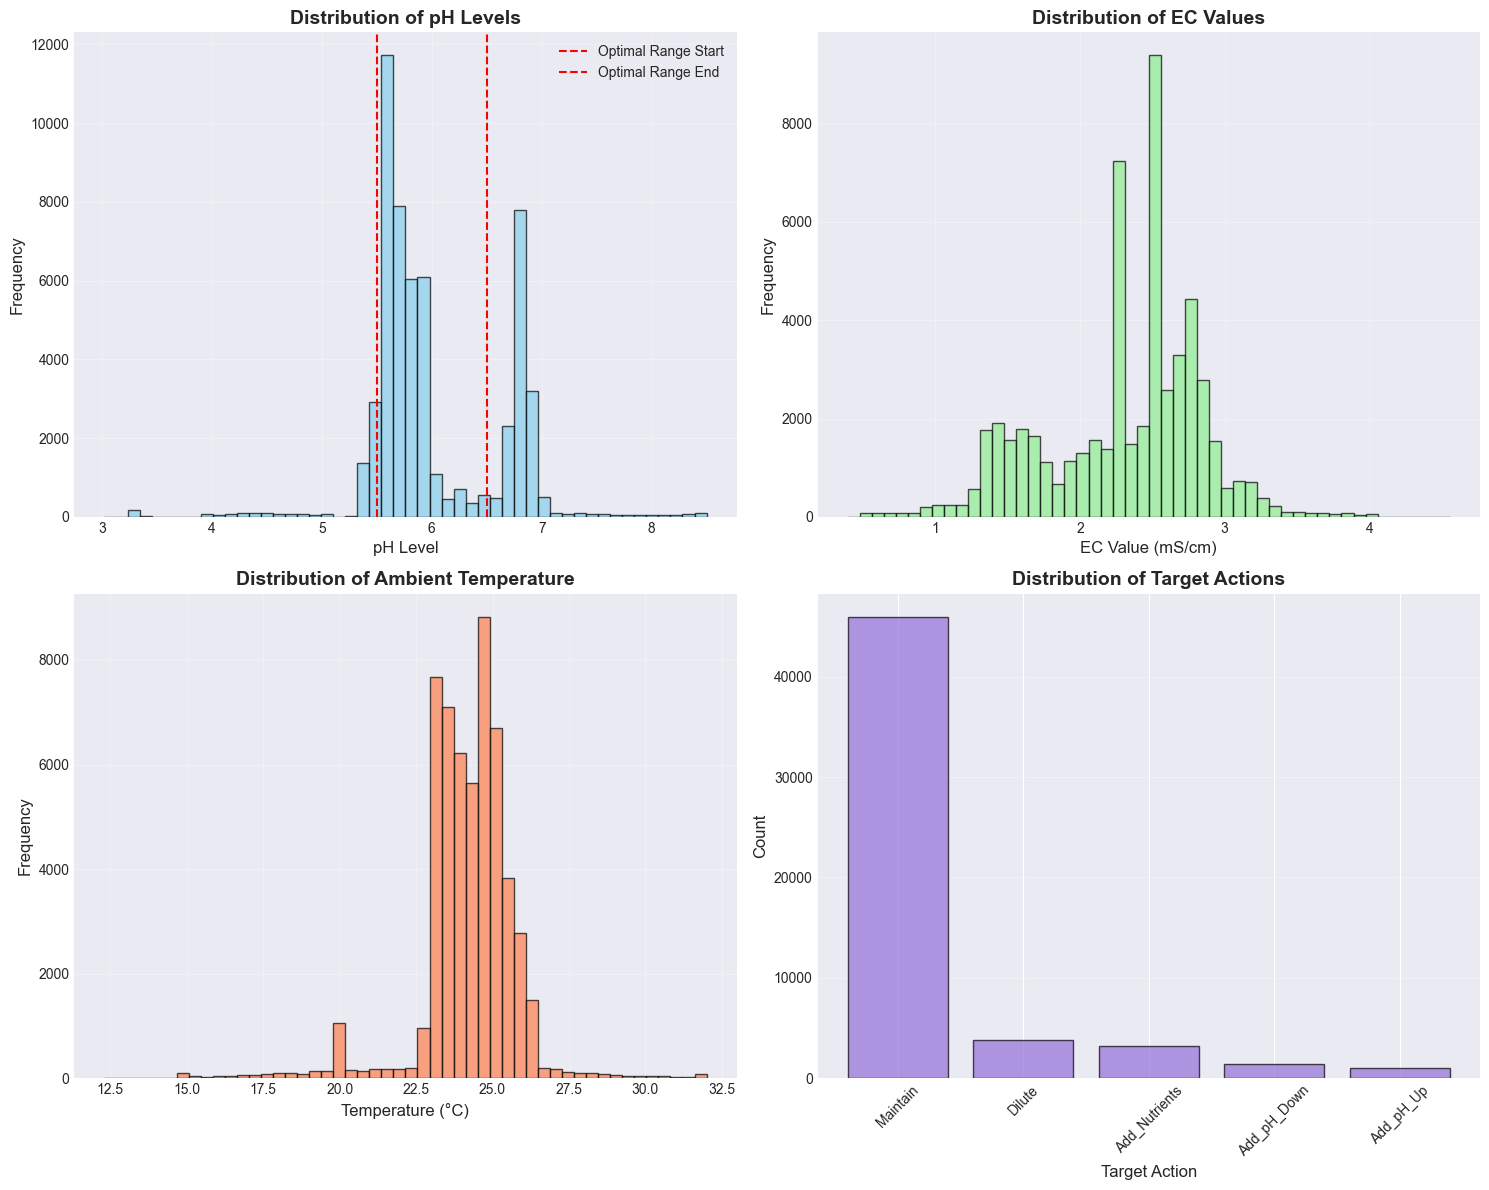

In [142]:
# 3.1 Data Distribution Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# pH Distribution
axes[0, 0].hist(final_dataset['pH_Level'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(5.5, color='red', linestyle='--', label='Optimal Range Start')
axes[0, 0].axvline(6.5, color='red', linestyle='--', label='Optimal Range End')
axes[0, 0].set_xlabel('pH Level', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of pH Levels', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# EC Distribution
axes[0, 1].hist(final_dataset['EC_Value'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('EC Value (mS/cm)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of EC Values', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Temperature Distribution
axes[1, 0].hist(final_dataset['Ambient_Temp'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_xlabel('Temperature (°C)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Ambient Temperature', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Target Action Distribution
action_counts = final_dataset['Target_Action'].value_counts()
axes[1, 1].bar(action_counts.index, action_counts.values, color='mediumpurple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Target Action', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Distribution of Target Actions', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'data_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


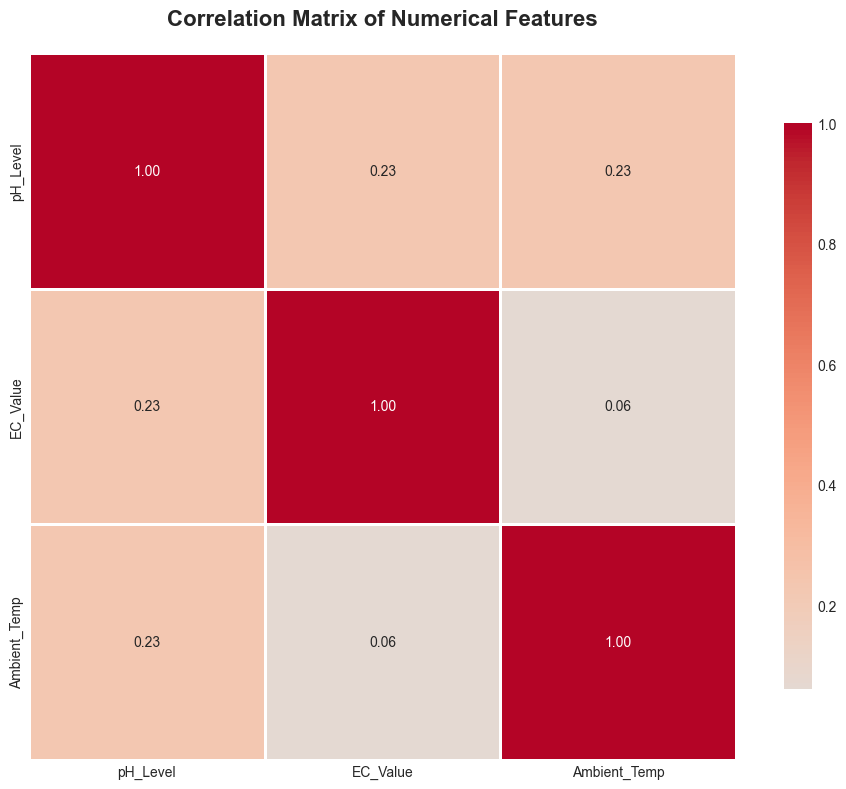

In [143]:
# 3.2 Correlation Matrix
numeric_cols = ['pH_Level', 'EC_Value', 'Ambient_Temp']
correlation_matrix = final_dataset[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(RESULTS_DIR/'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


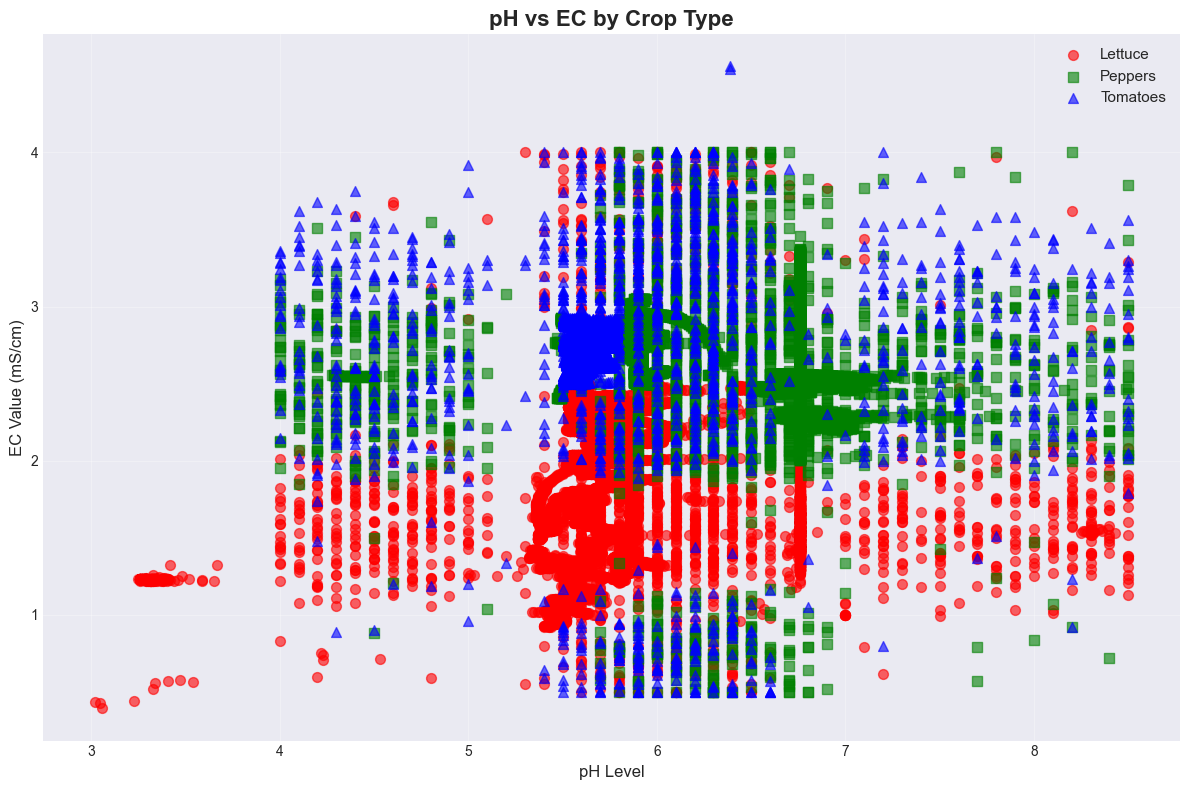

In [144]:
# 3.3 pH vs EC Scatter Plot by Crop
fig, ax = plt.subplots(figsize=(12, 8))

crops = final_dataset['Crop_ID'].unique()
colors = ['red', 'green', 'blue']
markers = ['o', 's', '^']

for crop, color, marker in zip(crops, colors, markers):
    crop_data = final_dataset[final_dataset['Crop_ID'] == crop]
    ax.scatter(crop_data['pH_Level'], crop_data['EC_Value'], 
              label=crop, alpha=0.6, s=50, color=color, marker=marker)

ax.set_xlabel('pH Level', fontsize=12)
ax.set_ylabel('EC Value (mS/cm)', fontsize=12)
ax.set_title('pH vs EC by Crop Type', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR/'ph_ec_by_crop.png', dpi=300, bbox_inches='tight')
plt.show()


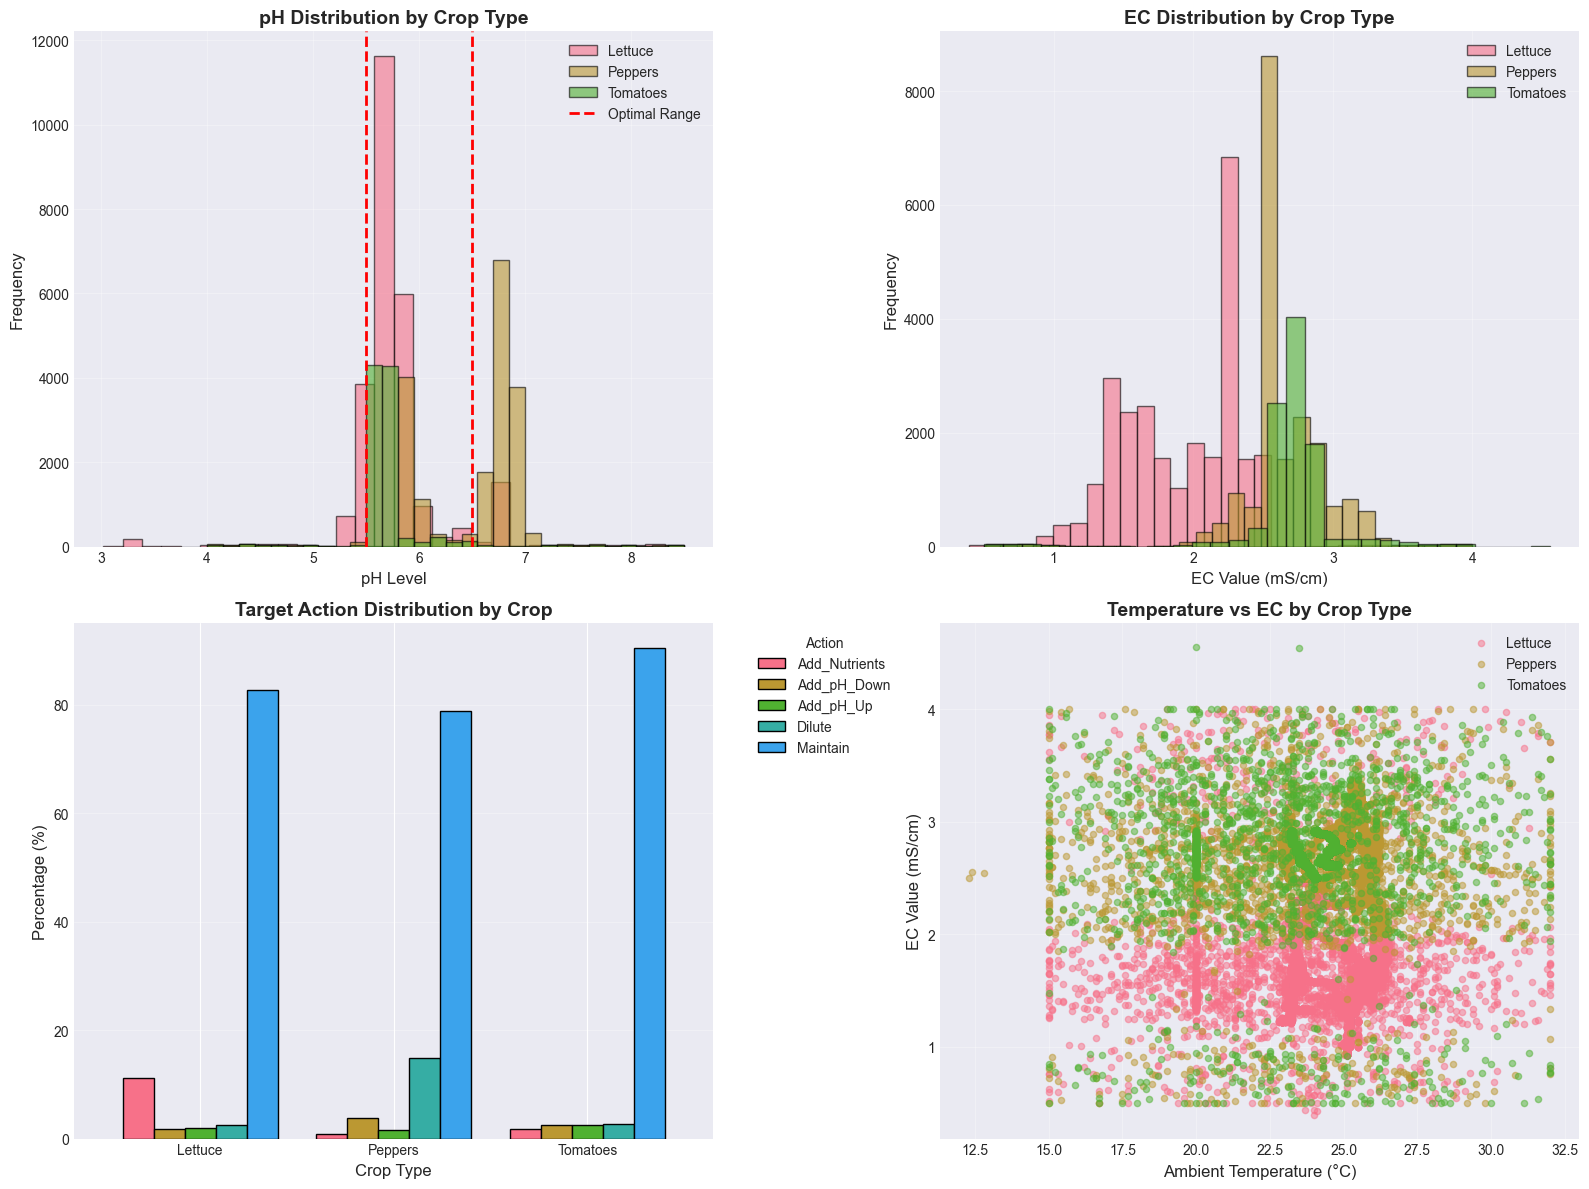

CROP-SPECIFIC STATISTICS

Lettuce:
  Count: 26,283
  pH - Mean: 5.76, Std: 0.46
  EC - Mean: 1.92, Std: 0.44
  Temp - Mean: 24.05°C, Std: 1.41°C

Peppers:
  Count: 19,331
  pH - Mean: 6.51, Std: 0.52
  EC - Mean: 2.64, Std: 0.32
  Temp - Mean: 24.59°C, Std: 1.62°C

Tomatoes:
  Count: 9,911
  pH - Mean: 5.71, Std: 0.42
  EC - Mean: 2.71, Std: 0.36
  Temp - Mean: 23.84°C, Std: 1.77°C


In [145]:
# 3.5 Crop-Specific Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# pH distribution by crop
for crop in final_dataset['Crop_ID'].unique():
    crop_data = final_dataset[final_dataset['Crop_ID'] == crop]
    axes[0, 0].hist(crop_data['pH_Level'], bins=30, alpha=0.6, label=crop, edgecolor='black')
axes[0, 0].axvline(5.5, color='red', linestyle='--', linewidth=2, label='Optimal Range')
axes[0, 0].axvline(6.5, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('pH Level', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('pH Distribution by Crop Type', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# EC distribution by crop
for crop in final_dataset['Crop_ID'].unique():
    crop_data = final_dataset[final_dataset['Crop_ID'] == crop]
    axes[0, 1].hist(crop_data['EC_Value'], bins=30, alpha=0.6, label=crop, edgecolor='black')
axes[0, 1].set_xlabel('EC Value (mS/cm)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('EC Distribution by Crop Type', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Action distribution by crop
action_by_crop = pd.crosstab(final_dataset['Crop_ID'], final_dataset['Target_Action'], normalize='index') * 100
action_by_crop.plot(kind='bar', ax=axes[1, 0], width=0.8, edgecolor='black')
axes[1, 0].set_xlabel('Crop Type', fontsize=12)
axes[1, 0].set_ylabel('Percentage (%)', fontsize=12)
axes[1, 0].set_title('Target Action Distribution by Crop', fontsize=14, fontweight='bold')
axes[1, 0].legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Temperature vs EC by crop (scatter)
for crop in final_dataset['Crop_ID'].unique():
    crop_data = final_dataset[final_dataset['Crop_ID'] == crop]
    axes[1, 1].scatter(crop_data['Ambient_Temp'], crop_data['EC_Value'], 
                      alpha=0.5, label=crop, s=20)
axes[1, 1].set_xlabel('Ambient Temperature (°C)', fontsize=12)
axes[1, 1].set_ylabel('EC Value (mS/cm)', fontsize=12)
axes[1, 1].set_title('Temperature vs EC by Crop Type', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR/'crop_specific_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print crop-specific statistics
print("CROP-SPECIFIC STATISTICS")
for crop in final_dataset['Crop_ID'].unique():
    crop_data = final_dataset[final_dataset['Crop_ID'] == crop]
    print(f"\n{crop}:")
    print(f"  Count: {len(crop_data):,}")
    print(f"  pH - Mean: {crop_data['pH_Level'].mean():.2f}, Std: {crop_data['pH_Level'].std():.2f}")
    print(f"  EC - Mean: {crop_data['EC_Value'].mean():.2f}, Std: {crop_data['EC_Value'].std():.2f}")
    print(f"  Temp - Mean: {crop_data['Ambient_Temp'].mean():.2f}°C, Std: {crop_data['Ambient_Temp'].std():.2f}°C")


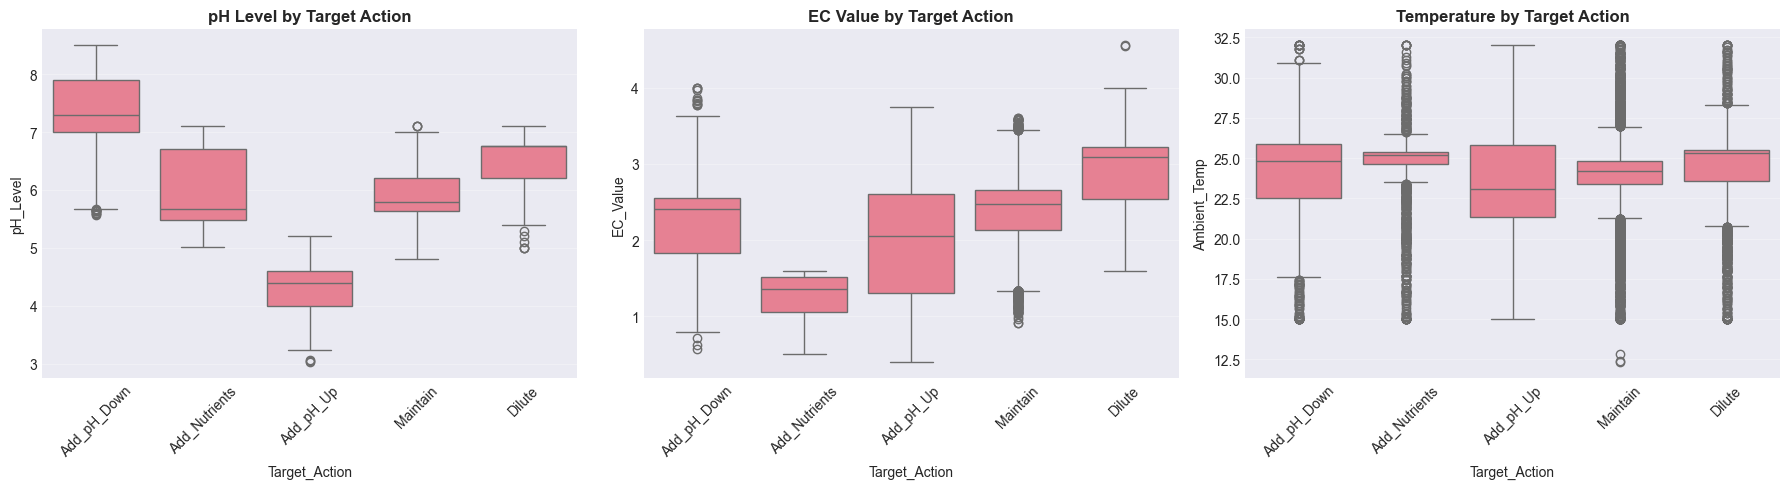

In [146]:
# 3.4 Box Plots for Feature Distributions by Target Action
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# pH by Action
sns.boxplot(data=final_dataset, x='Target_Action', y='pH_Level', ax=axes[0])
axes[0].set_title('pH Level by Target Action', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# EC by Action
sns.boxplot(data=final_dataset, x='Target_Action', y='EC_Value', ax=axes[1])
axes[1].set_title('EC Value by Target Action', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

# Temperature by Action
sns.boxplot(data=final_dataset, x='Target_Action', y='Ambient_Temp', ax=axes[2])
axes[2].set_title('Temperature by Target Action', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR/'features_by_action.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Model Architecture


In [147]:
# Prepare data for modeling
print("Preparing data for ML models...")

# Encode categorical variables
le_crop = LabelEncoder()
le_action = LabelEncoder()

X = final_dataset.copy()
X['Crop_ID_encoded'] = le_crop.fit_transform(X['Crop_ID'])
X['Target_Action_encoded'] = le_action.fit_transform(X['Target_Action'])

# Features: Crop_ID, pH_Level, EC_Value, Ambient_Temp
feature_cols = ['Crop_ID_encoded', 'pH_Level', 'EC_Value', 'Ambient_Temp']
X_features = X[feature_cols]
y = X['Target_Action_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]:,}")
print(f"Test set size: {X_test.shape[0]:,}")
print(f"\nFeature columns: {feature_cols}")
print(f"\nNumber of classes: {len(le_action.classes_)}")
print(f"Classes: {le_action.classes_}")


Preparing data for ML models...
Training set size: 44,420
Test set size: 11,105

Feature columns: ['Crop_ID_encoded', 'pH_Level', 'EC_Value', 'Ambient_Temp']

Number of classes: 5
Classes: ['Add_Nutrients' 'Add_pH_Down' 'Add_pH_Up' 'Dilute' 'Maintain']


### 4.1 Random Forest Classifier Architecture

**Model Type:** Random Forest Classifier  
**Algorithm:** Ensemble Learning (Bagging)  
**Base Estimators:** Decision Trees  
**Number of Trees:** 100 (default)  
**Criterion:** Gini Impurity  
**Max Depth:** None (unlimited)  
**Min Samples Split:** 2  
**Min Samples Leaf:** 1  
**Bootstrap:** True  
**Random State:** 42

**Architecture Flow:**
1. Input Layer: 4 features (Crop_ID, pH_Level, EC_Value, Ambient_Temp)
2. Feature Processing: No scaling required (tree-based models)
3. Ensemble Layer: 100 decision trees vote on classification
4. Output Layer: 5 classes (Add_pH_Down, Add_pH_Up, Add_Nutrients, Dilute, Maintain)


In [148]:
# Train Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)
print("Random Forest training completed!")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s


Random Forest training completed!

Feature Importance:
           Feature  Importance
2         EC_Value    0.464329
1         pH_Level    0.346710
3     Ambient_Temp    0.166854
0  Crop_ID_encoded    0.022107


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


### 4.2 Linear Regression Architecture (for Regression Tasks)

**Model Type:** Linear Regression  
**Algorithm:** Ordinary Least Squares (OLS)  
**Optimization:** Normal Equation / Gradient Descent  
**Regularization:** None  
**Solver:** 'auto' (uses SVD or Cholesky)

**Architecture Flow:**
1. Input Layer: 4 features (scaled)
2. Weight Matrix: 4x1 (one weight per feature + bias)
3. Linear Transformation: y = w₁x₁ + w₂x₂ + w₃x₃ + w₄x₄ + b
4. Output: Continuous value (for regression) or logits (for classification)


In [149]:
# Train Logistic Regression (for classification comparison)
print("Training Logistic Regression Classifier...")

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs'
)

lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression training completed!")


Training Logistic Regression Classifier...
Logistic Regression training completed!


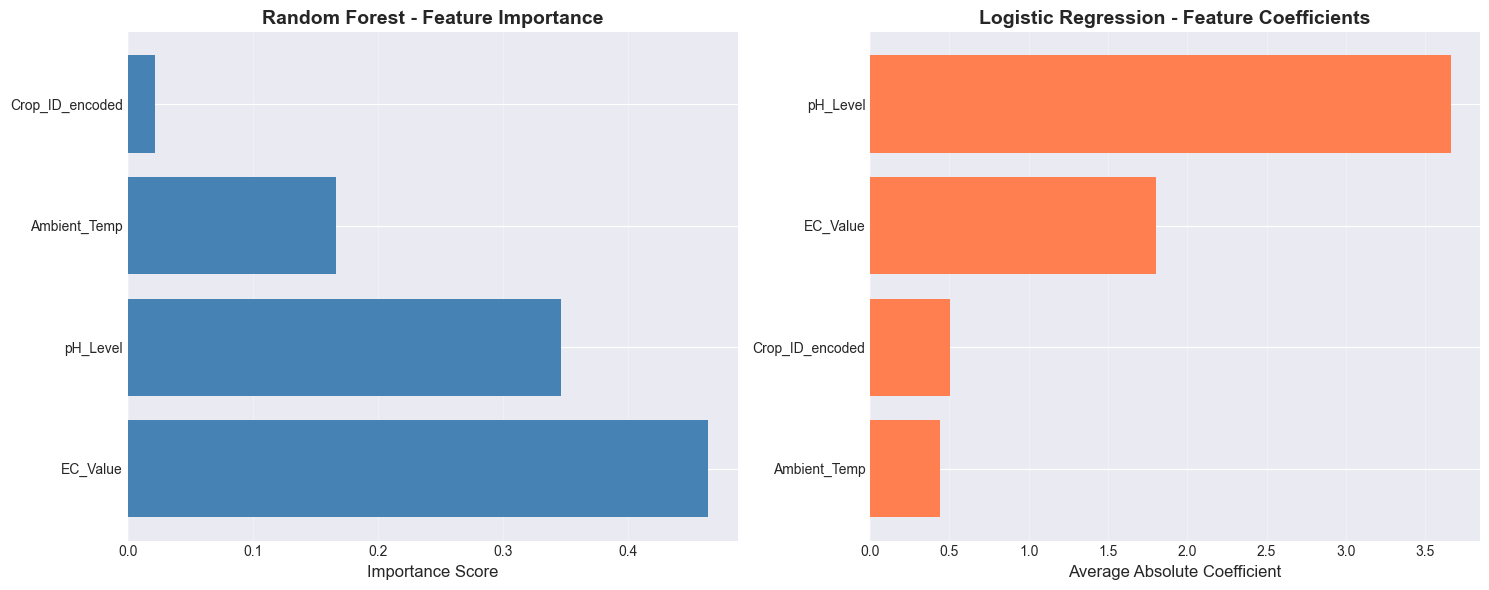

In [150]:
# Visualize Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest Feature Importance
axes[0].barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Logistic Regression Coefficients (average across classes)
lr_coef_avg = np.mean(np.abs(lr_model.coef_), axis=0)
lr_feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_coef_avg
}).sort_values('Coefficient', ascending=True)

axes[1].barh(lr_feature_importance['Feature'], lr_feature_importance['Coefficient'], color='coral')
axes[1].set_xlabel('Average Absolute Coefficient', fontsize=12)
axes[1].set_title('Logistic Regression - Feature Coefficients', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_DIR/'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Performance Metrics


In [151]:
# Predictions
rf_predictions = rf_model.predict(X_test)
lr_predictions = lr_model.predict(X_test_scaled)

# Get prediction probabilities
rf_proba = rf_model.predict_proba(X_test)
lr_proba = lr_model.predict_proba(X_test_scaled)

# Calculate metrics for Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions, average='weighted', zero_division=0)
rf_recall = recall_score(y_test, rf_predictions, average='weighted', zero_division=0)
rf_f1 = f1_score(y_test, rf_predictions, average='weighted', zero_division=0)

# Calculate metrics for Logistic Regression
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions, average='weighted', zero_division=0)
lr_recall = recall_score(y_test, lr_predictions, average='weighted', zero_division=0)
lr_f1 = f1_score(y_test, lr_predictions, average='weighted', zero_division=0)

# Create metrics comparison
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [rf_accuracy, lr_accuracy],
    'Precision': [rf_precision, lr_precision],
    'Recall': [rf_recall, lr_recall],
    'F1-Score': [rf_f1, lr_f1]
})

print("PERFORMANCE METRICS COMPARISON")
print(metrics_df.to_string(index=False))
print("\n")


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


PERFORMANCE METRICS COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.987483   0.987377 0.987483  0.987383
Logistic Regression  0.935434   0.936681 0.935434  0.929571




[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


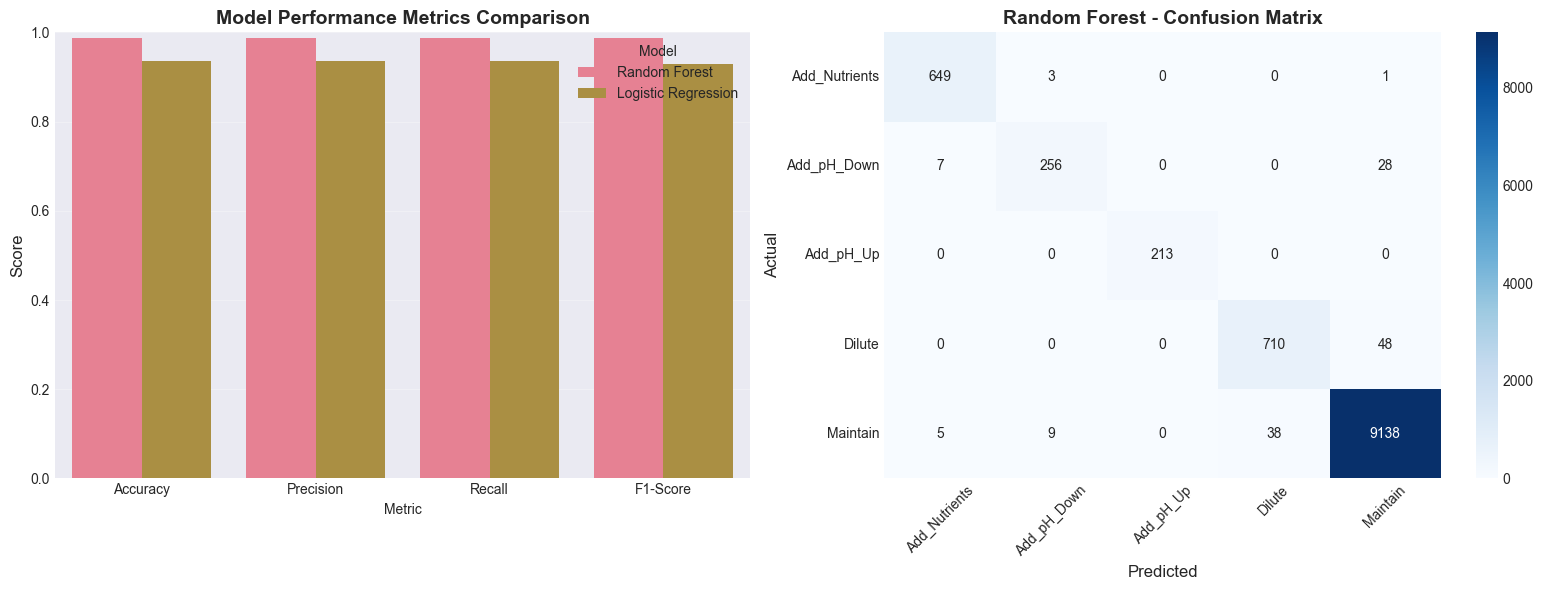

In [152]:
# Visualize Performance Metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics Comparison Bar Chart
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='Model', ax=axes[0])
axes[0].set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].legend(title='Model', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=le_action.classes_, yticklabels=le_action.classes_)
axes[1].set_title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig(RESULTS_DIR/'performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


In [153]:
# Detailed Classification Report
print("RANDOM FOREST - DETAILED CLASSIFICATION REPORT")
print(classification_report(y_test, rf_predictions, 
                          target_names=le_action.classes_, 
                          zero_division=0))

print("LOGISTIC REGRESSION - DETAILED CLASSIFICATION REPORT")
print(classification_report(y_test, lr_predictions, 
                          target_names=le_action.classes_, 
                          zero_division=0))


RANDOM FOREST - DETAILED CLASSIFICATION REPORT
               precision    recall  f1-score   support

Add_Nutrients       0.98      0.99      0.99       653
  Add_pH_Down       0.96      0.88      0.92       291
    Add_pH_Up       1.00      1.00      1.00       213
       Dilute       0.95      0.94      0.94       758
     Maintain       0.99      0.99      0.99      9190

     accuracy                           0.99     11105
    macro avg       0.98      0.96      0.97     11105
 weighted avg       0.99      0.99      0.99     11105

LOGISTIC REGRESSION - DETAILED CLASSIFICATION REPORT
               precision    recall  f1-score   support

Add_Nutrients       0.86      0.68      0.76       653
  Add_pH_Down       1.00      0.61      0.76       291
    Add_pH_Up       1.00      0.99      1.00       213
       Dilute       0.99      0.57      0.72       758
     Maintain       0.93      0.99      0.96      9190

     accuracy                           0.94     11105
    macro avg  

In [154]:
# Save models and encoders
print("Saving models and encoders...")
joblib.dump(rf_model, RESULTS_DIR/'random_forest_model.pkl')
joblib.dump(lr_model, RESULTS_DIR/'logistic_regression_model.pkl')
joblib.dump(scaler, RESULTS_DIR/'feature_scaler.pkl')
joblib.dump(le_crop, RESULTS_DIR/'crop_encoder.pkl')
joblib.dump(le_action, RESULTS_DIR/'action_encoder.pkl')

# Save metadata
metadata = {
    'feature_columns': feature_cols,
    'crop_classes': le_crop.classes_.tolist(),
    'action_classes': le_action.classes_.tolist(),
    'model_performance': {
        'random_forest': {
            'accuracy': float(rf_accuracy),
            'precision': float(rf_precision),
            'recall': float(rf_recall),
            'f1_score': float(rf_f1)
        },
        'logistic_regression': {
            'accuracy': float(lr_accuracy),
            'precision': float(lr_precision),
            'recall': float(lr_recall),
            'f1_score': float(lr_f1)
        }
    }
}

with open(RESULTS_DIR/'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Models and metadata saved successfully!")
print(f"\nBest Model: Random Forest (Accuracy: {rf_accuracy:.4f})")


Saving models and encoders...
Models and metadata saved successfully!

Best Model: Random Forest (Accuracy: 0.9875)


## 6. Deployment Option: Flask API with Swagger UI

The following section creates a Flask REST API with Swagger UI documentation for deploying the ML model.


In [155]:
# Create Flask API code
flask_api_code = '''
from flask import Flask, request, jsonify
from flask_restx import Api, Resource, fields
import joblib
import numpy as np
import os

app = Flask(__name__)
api = Api(app, 
          version='1.0', 
          title='EzaSmart Hydroponics API',
          description='Hydroponics Management System API',
          doc='/swagger/')

# Load models and encoders
try:
    rf_model = joblib.load('random_forest_model.pkl')
    scaler = joblib.load('feature_scaler.pkl')
    le_crop = joblib.load('crop_encoder.pkl')
    le_action = joblib.load('action_encoder.pkl')
    print("Models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}")
    rf_model = None

# Define request/response models
prediction_model = api.model('PredictionRequest', {
    'crop_id': fields.String(required=True, description='Crop type: Lettuce, Peppers, or Tomatoes'),
    'ph_level': fields.Float(required=True, description='pH level (4.0-8.5)'),
    'ec_value': fields.Float(required=True, description='EC value in mS/cm (0.5-4.0)'),
    'ambient_temp': fields.Float(required=True, description='Ambient temperature in Celsius (15-32)')
})

response_model = api.model('PredictionResponse', {
    'predicted_action': fields.String(description='Recommended action'),
    'confidence': fields.Float(description='Prediction confidence score'),
    'all_probabilities': fields.Raw(description='Probabilities for all actions'),
    'recommendation': fields.String(description='Detailed recommendation')
})

@api.route('/predict')
class Predict(Resource):
    @api.expect(prediction_model)
    @api.marshal_with(response_model)
    def post(self):
        """Get hydroponic management recommendation based on sensor readings"""
        if rf_model is None:
            return {'error': 'Model not loaded'}, 500
        
        data = request.json
        
        # Validate inputs
        crop = data.get('crop_id')
        ph = data.get('ph_level')
        ec = data.get('ec_value')
        temp = data.get('ambient_temp')
        
        if crop not in ['Lettuce', 'Peppers', 'Tomatoes']:
            return {'error': 'Invalid crop_id. Must be Lettuce, Peppers, or Tomatoes'}, 400
        
        if not (4.0 <= ph <= 8.5):
            return {'error': 'pH level must be between 4.0 and 8.5'}, 400
        
        if not (0.5 <= ec <= 4.0):
            return {'error': 'EC value must be between 0.5 and 4.0 mS/cm'}, 400
        
        if not (15 <= temp <= 32):
            return {'error': 'Temperature must be between 15 and 32°C'}, 400
        
        # Encode crop
        crop_encoded = le_crop.transform([crop])[0]
        
        # Prepare features
        features = np.array([[crop_encoded, ph, ec, temp]])
        
        # Predict
        prediction = rf_model.predict(features)[0]
        probabilities = rf_model.predict_proba(features)[0]
        
        # Decode action
        predicted_action = le_action.inverse_transform([prediction])[0]
        confidence = float(max(probabilities))
        
        # Create probability dictionary
        all_probs = {
            le_action.classes_[i]: float(prob) 
            for i, prob in enumerate(probabilities)
        }
        
        # Generate recommendation
        recommendations = {
            'Add_pH_Down': f'pH level ({ph:.1f}) is too high. Add pH Down solution to lower pH to optimal range (5.5-6.5).',
            'Add_pH_Up': f'pH level ({ph:.1f}) is too low. Add pH Up solution to raise pH to optimal range (5.5-6.5).',
            'Add_Nutrients': f'EC value ({ec:.2f} mS/cm) is too low. Add nutrient solution to increase nutrient concentration.',
            'Dilute': f'EC value ({ec:.2f} mS/cm) is too high. Dilute the solution with fresh water to reduce concentration.',
            'Maintain': f'Current conditions are optimal. pH: {ph:.1f}, EC: {ec:.2f} mS/cm. Continue monitoring.'
        }
        
        recommendation = recommendations.get(predicted_action, 'Monitor your system closely.')
        
        return {
            'predicted_action': predicted_action,
            'confidence': confidence,
            'all_probabilities': all_probs,
            'recommendation': recommendation
        }

@api.route('/health')
class Health(Resource):
    def get(self):
        """Health check endpoint"""
        return {
            'status': 'healthy',
            'model_loaded': rf_model is not None
        }

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)
'''

# Save Flask API code
with open('app.py', 'w') as f:
    f.write(flask_api_code)

print("Flask API code created: app.py")
print("\nTo run the API:")
print("1. Install dependencies: pip install flask flask-restx joblib")
print("2. Run: python app.py")
print("3. Access Swagger UI at: http://localhost:5000/swagger/")


Flask API code created: app.py

To run the API:
1. Install dependencies: pip install flask flask-restx joblib
2. Run: python app.py
3. Access Swagger UI at: http://localhost:5000/swagger/


### 6.3 API Testing with Postman/Swagger UI

The Flask API includes Swagger UI for interactive testing:

1. **Start the API server:**
   ```bash
   python app.py
   ```

2. **Access Swagger UI:**
   - Open browser: `http://localhost:5000/swagger/`
   - Interactive API documentation with "Try it out" functionality

3. **Example API Request (JSON):**
   ```json
   {
     "crop_id": "Lettuce",
     "ph_level": 7.5,
     "ec_value": 2.5,
     "ambient_temp": 25.0
   }
   ```

4. **Example API Response:**
   ```json
   {
     "predicted_action": "Add_pH_Down",
     "confidence": 0.95,
     "all_probabilities": {
       "Add_pH_Down": 0.95,
       "Add_pH_Up": 0.02,
       "Add_Nutrients": 0.01,
       "Dilute": 0.01,
       "Maintain": 0.01
     },
     "recommendation": "pH level (7.5) is too high. Add pH Down solution to lower pH to optimal range (5.5-6.5)."
   }
   ```
